In [1]:
%load_ext autoreload
%autoreload 2

import nest
import numpy as np
import params
from math import degrees
import matplotlib.pyplot as plt
from nest_tools import Network, SpikeRecording
import mnist_tools

mnist_tools.ensure_path('mnist_experiments')

# reseed numpy
np.random.seed(0)

# load data - some preprocessing is done in the module (reshaping)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = mnist_tools.load_mnist_data()

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)


######### rate 15000.000000000004
(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


In [2]:
def simulate(rates, digits, digit_labels, name, duration=1000.0):
    network = Network()
    network.reset_nest()
    network.setup_static_network()
    network.record_spikes(name)
    
    for i, digit in enumerate(digits):
        # set rate for every neuron

        for j, rate in enumerate(rates[i]):
            network.set_rate([j+1], rate)

        print(str(i+1)+". stimulus = "+str(digit_labels[i])+", simulating for", duration)
        nest.Simulate(duration)

    network.save_recording(name)

## Inspection of population firing depending on different standardization

These spike recordings use a) standardization per sample and b) standardization over all input activations

1. stimulus = 5, simulating for 1000.0
2. stimulus = 0, simulating for 1000.0
3. stimulus = 4, simulating for 1000.0
4. stimulus = 1, simulating for 1000.0
5. stimulus = 9, simulating for 1000.0
6. stimulus = 2, simulating for 1000.0
7. stimulus = 1, simulating for 1000.0
8. stimulus = 3, simulating for 1000.0
9. stimulus = 1, simulating for 1000.0
10. stimulus = 4, simulating for 1000.0
saving to mnist_experiments/firing1.0.npy


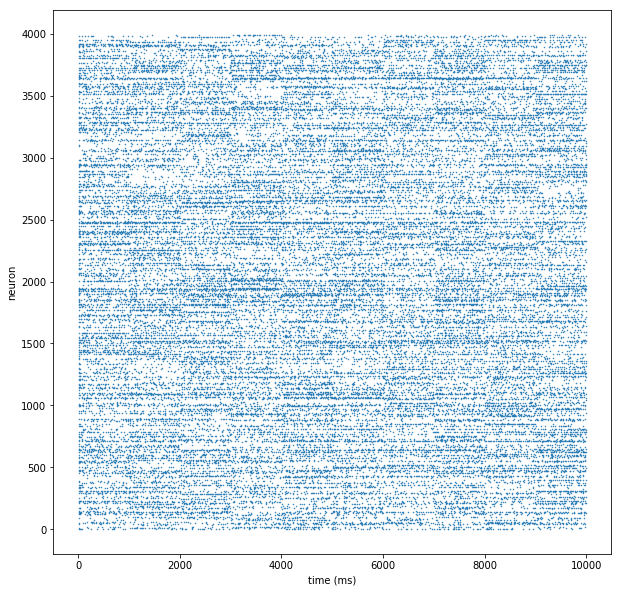

In [3]:
test_digits = x_train[:10]
test_labels = y_train[:10]

pixel_samples = mnist_tools.create_samples(4000, 40)
input_rates = mnist_tools.calc_rates(test_digits, pixel_samples, standardize_per_digit=True) * params.rate
simulate(input_rates, test_digits, test_labels, 'mnist_experiments/firing1')
recording = SpikeRecording.from_file('mnist_experiments/firing1')

# plot every 10th neuron
plt.figure(figsize=(10,10))
recording.plot(neurons=range(1,4000,10))
    

1. stimulus = 5, simulating for 1000.0
2. stimulus = 0, simulating for 1000.0
3. stimulus = 4, simulating for 1000.0
4. stimulus = 1, simulating for 1000.0
5. stimulus = 9, simulating for 1000.0
6. stimulus = 2, simulating for 1000.0
7. stimulus = 1, simulating for 1000.0
8. stimulus = 3, simulating for 1000.0
9. stimulus = 1, simulating for 1000.0
10. stimulus = 4, simulating for 1000.0
saving to mnist_experiments/firing2.0.npy


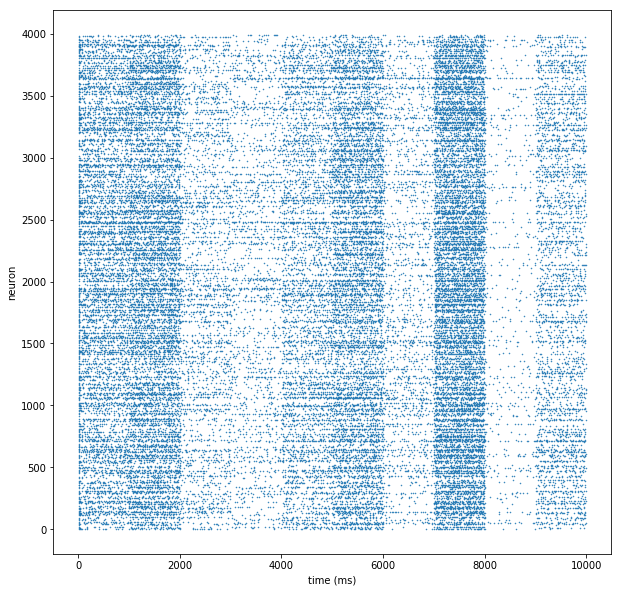

In [4]:
input_rates = mnist_tools.calc_rates(test_digits, pixel_samples, standardize_per_digit=False) * params.rate
simulate(input_rates, test_digits, test_labels, 'mnist_experiments/firing2')
recording = SpikeRecording.from_file('mnist_experiments/firing2')

# plot every 10th neuron
plt.figure(figsize=(10,10))
recording.plot(neurons=range(1,4000,10))


## Experiment 1

Run the network on one sample of the input digits 0, 1, 2, 3, ... , 9 each - then calculate the entropy for each neuron at the input and at the output and compare.

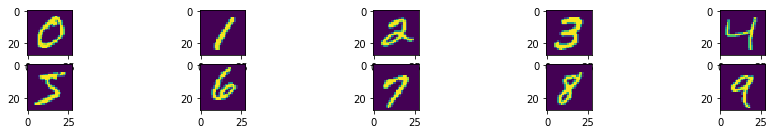

In [5]:
# create training set
digits = np.concatenate([ mnist_tools.get_sample_digits(x_train, y_train, 10, i) for i in range(10) ])
digit_labels = np.concatenate([ [i//10] for i in range(100) ])

digits = np.concatenate([ mnist_tools.get_sample_digits(x_train, y_train, 1, i) for i in range(10) ])
digit_labels = np.concatenate([ [i] for i in range(10) ])

plt.figure(figsize=(15,40))
for i, digit in enumerate(digits):
    plt.subplot(40,5, i+1)
    plt.imshow(digit)

In [6]:
# samples for each neuron
pixel_samples = mnist_tools.create_samples(4000, sample_size=40)
    
input_rates = mnist_tools.calc_rates(digits, pixel_samples, standardize_per_digit=True) * params.rate
mean_input_rates_per_digit =  mnist_tools.mean_rates_per_digit(digit_labels, input_rates)
input_entropies = mnist_tools.calc_entropies(mean_input_rates_per_digit)
    
simulate(input_rates, digits, digit_labels, 'mnist_experiments/experiment1')
recording = SpikeRecording.from_file('mnist_experiments/experiment1')
    
output_rates = np.stack([recording.rate(range(1,4001), i*1000, (i+1)*1000.0) for i in range(len(digits))])
mean_output_rates_per_digit =  mnist_tools.mean_rates_per_digit(digit_labels, output_rates)
output_entropies = mnist_tools.calc_entropies(mean_output_rates_per_digit)


1. stimulus = 0, simulating for 1000.0
2. stimulus = 1, simulating for 1000.0
3. stimulus = 2, simulating for 1000.0
4. stimulus = 3, simulating for 1000.0
5. stimulus = 4, simulating for 1000.0
6. stimulus = 5, simulating for 1000.0
7. stimulus = 6, simulating for 1000.0
8. stimulus = 7, simulating for 1000.0
9. stimulus = 8, simulating for 1000.0
10. stimulus = 9, simulating for 1000.0
saving to mnist_experiments/experiment1.0.npy


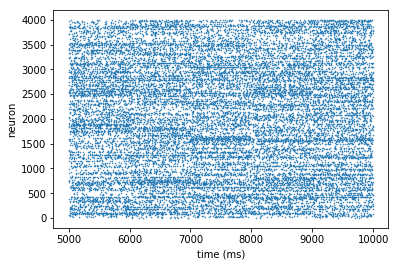

In [7]:
recording.plot(neurons=range(1,4000,10), start=5000, end=10000)

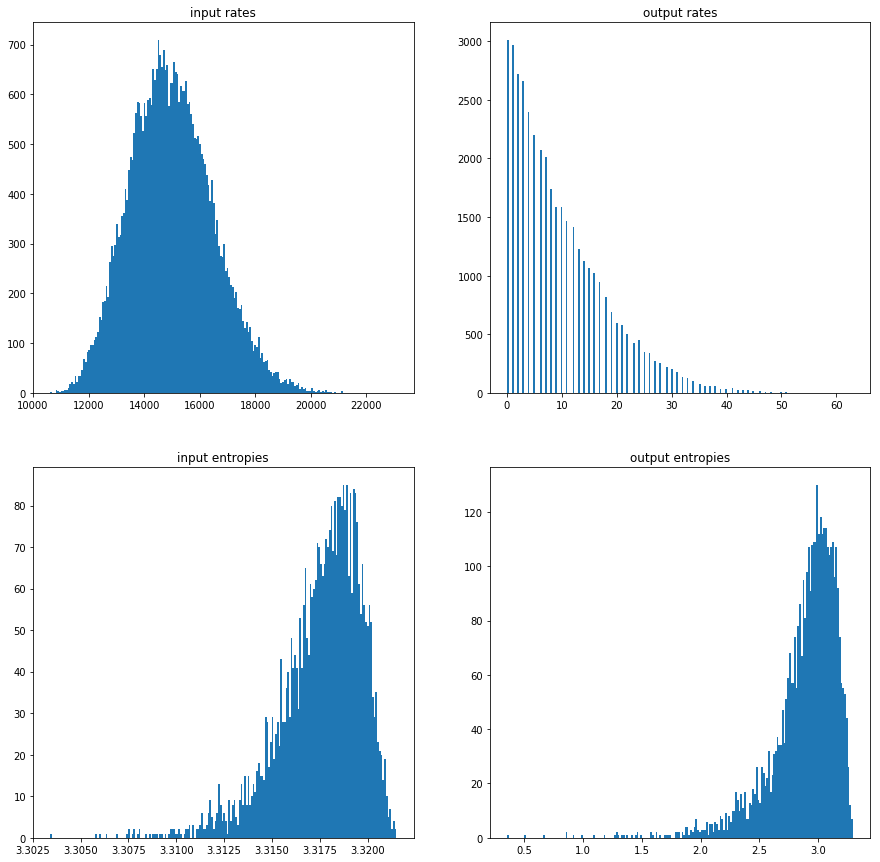

In [8]:
plt.figure(figsize=(15,15))
    
plt.subplot(2,2,1)
plt.title("input rates")
plt.hist(input_rates.ravel(), bins=200)

plt.subplot(2,2,2)
plt.title("output rates")
plt.hist(output_rates.ravel(), bins=200)
   
plt.subplot(2,2,3)
plt.title("input entropies")
plt.hist(input_entropies, bins=200)

plt.subplot(2,2,4)
plt.title("output entropies")
plt.hist(output_entropies, bins=200)
None

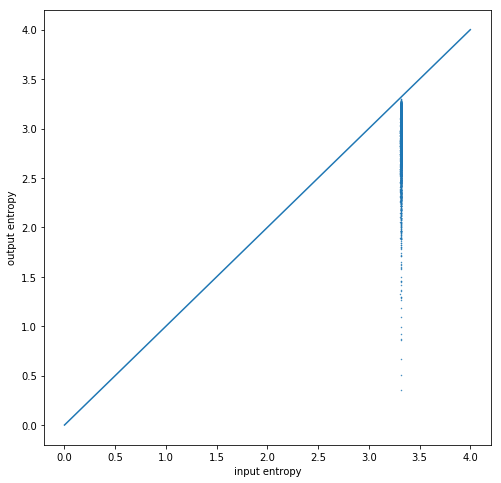

In [9]:
plt.figure(figsize=(8,8))
plt.scatter(input_entropies, output_entropies, s=0.2)
plt.xlabel("input entropy")
plt.ylabel("output entropy")
plt.plot([0,4], [0,4])

## Experiment 2

Run the network on ten samples of the input digits 0, 1, 2, 3, ... , 9 each - then calculate the entropy for each neuron at the input and at the output and compare.

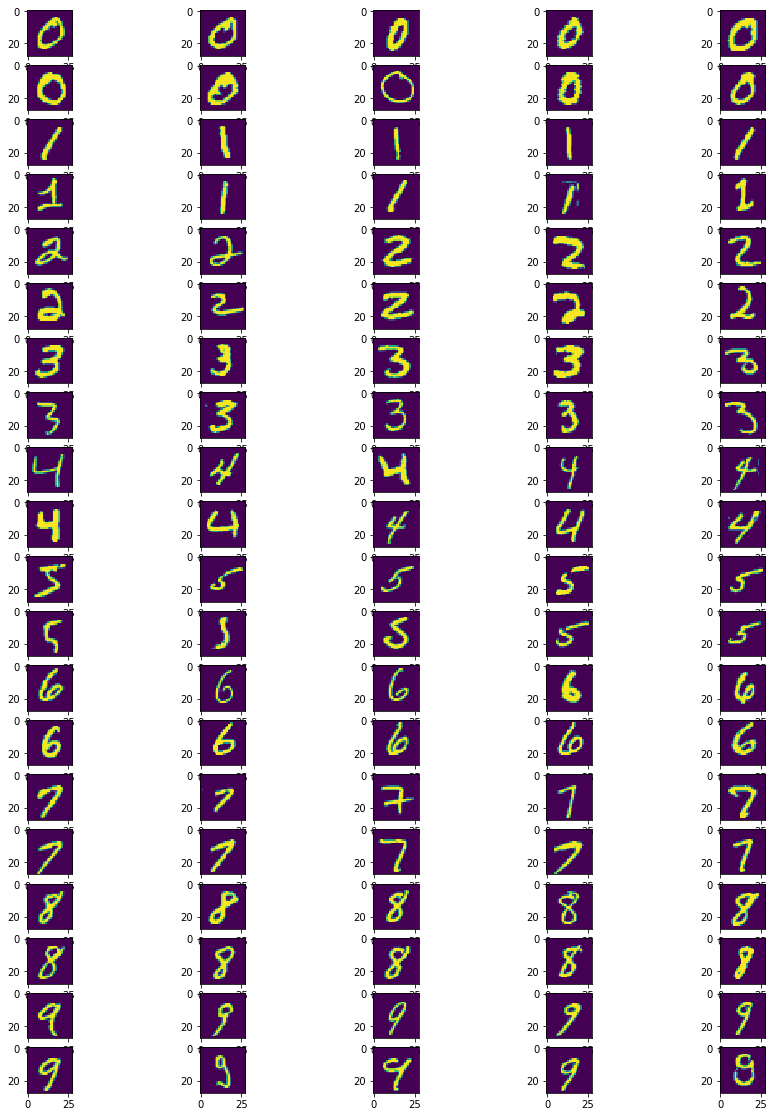

In [10]:
# create training set
digits = np.concatenate([ mnist_tools.get_sample_digits(x_train, y_train, 10, i) for i in range(10) ])
digit_labels = np.concatenate([ [i//10] for i in range(100) ])

plt.figure(figsize=(15,40))
for i, digit in enumerate(digits):
    plt.subplot(40,5, i+1)
    plt.imshow(digit)

In [17]:
# samples for each neuron
pixel_samples = mnist_tools.create_samples(4000, sample_size=40)
    
input_rates = mnist_tools.calc_rates(digits, pixel_samples, standardize_per_digit=True) * params.rate
mean_input_rates_per_digit =  mnist_tools.mean_rates_per_digit(digit_labels, input_rates)
input_entropies = mnist_tools.calc_entropies(mean_input_rates_per_digit)
    
simulate(input_rates, digits, digit_labels, 'mnist_experiments/experiment2')
recording = SpikeRecording.from_file('mnist_experiments/experiment2')

    
output_rates = np.stack([recording.rate(range(1,4001), i*1000, (i+1)*1000.0) for i in range(len(digits))])
mean_output_rates_per_digit = mnist_tools.mean_rates_per_digit(digit_labels, output_rates)
output_entropies = mnist_tools.calc_entropies(mean_output_rates_per_digit)


1. stimulus = 0, simulating for 1000.0
2. stimulus = 0, simulating for 1000.0
3. stimulus = 0, simulating for 1000.0
4. stimulus = 0, simulating for 1000.0
5. stimulus = 0, simulating for 1000.0
6. stimulus = 0, simulating for 1000.0
7. stimulus = 0, simulating for 1000.0
8. stimulus = 0, simulating for 1000.0
9. stimulus = 0, simulating for 1000.0
10. stimulus = 0, simulating for 1000.0
11. stimulus = 1, simulating for 1000.0
12. stimulus = 1, simulating for 1000.0
13. stimulus = 1, simulating for 1000.0
14. stimulus = 1, simulating for 1000.0
15. stimulus = 1, simulating for 1000.0
16. stimulus = 1, simulating for 1000.0
17. stimulus = 1, simulating for 1000.0
18. stimulus = 1, simulating for 1000.0
19. stimulus = 1, simulating for 1000.0
20. stimulus = 1, simulating for 1000.0
21. stimulus = 2, simulating for 1000.0
22. stimulus = 2, simulating for 1000.0
23. stimulus = 2, simulating for 1000.0
24. stimulus = 2, simulating for 1000.0
25. stimulus = 2, simulating for 1000.0
26. stimu

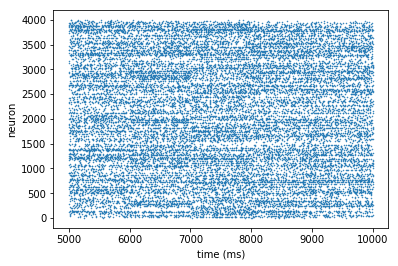

In [18]:
recording.plot(neurons=range(1,4000,10), start=5000, end=10000)

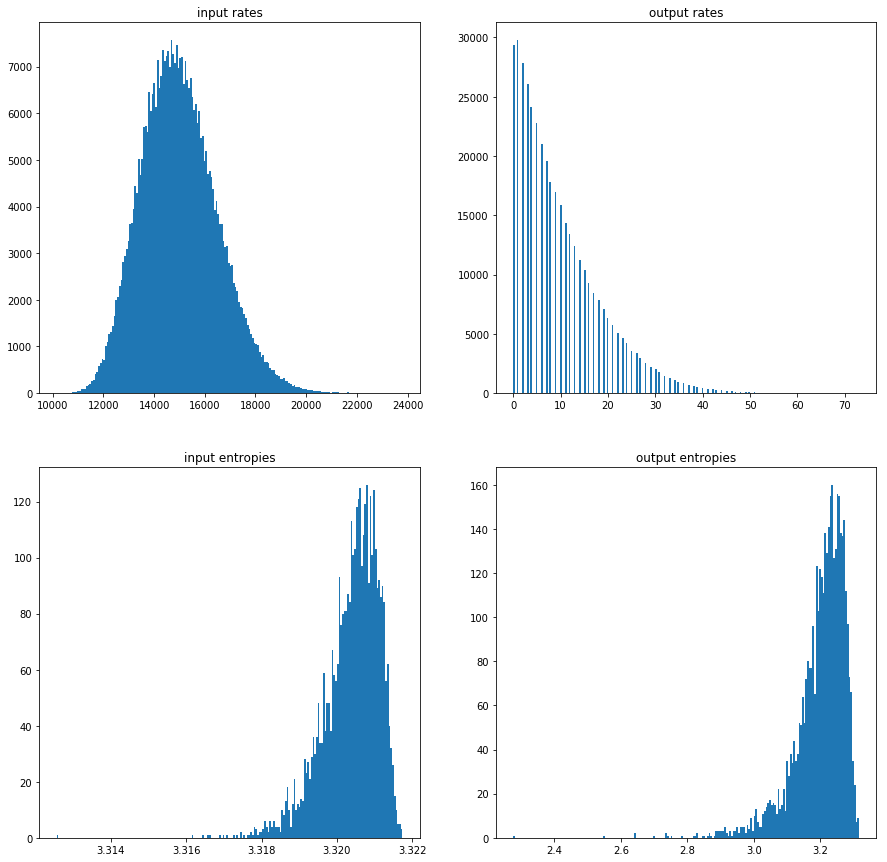

In [19]:
plt.figure(figsize=(15,15))
    
plt.subplot(2,2,1)
plt.title("input rates")
plt.hist(input_rates.ravel(), bins=200)

plt.subplot(2,2,2)
plt.title("output rates")
plt.hist(output_rates.ravel(), bins=200)
   
plt.subplot(2,2,3)
plt.title("input entropies")
plt.hist(input_entropies, bins=200)

plt.subplot(2,2,4)
plt.title("output entropies")
plt.hist(output_entropies, bins=200)
None

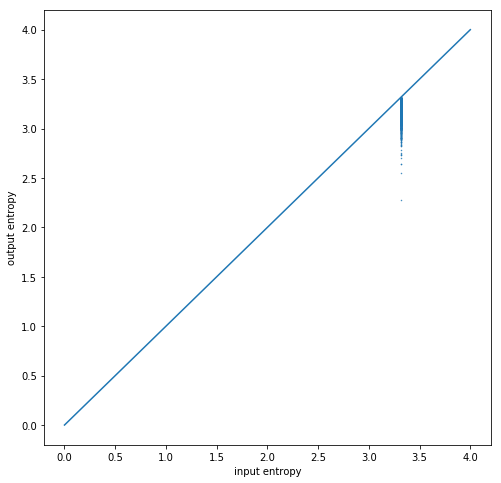

In [20]:
plt.figure(figsize=(8,8))
plt.scatter(input_entropies, output_entropies, s=0.2)
plt.xlabel("input entropy")
plt.ylabel("output entropy")
plt.plot([0,4], [0,4])

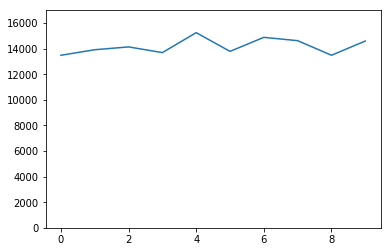

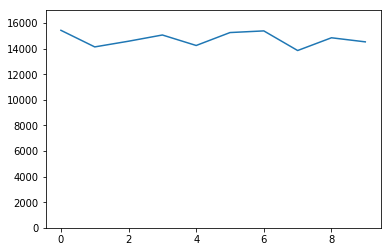

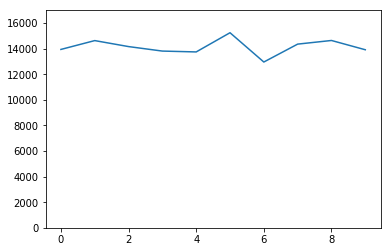

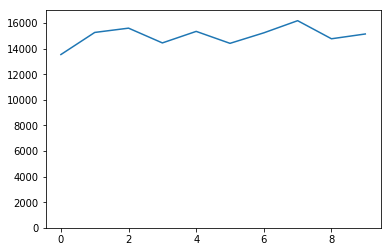

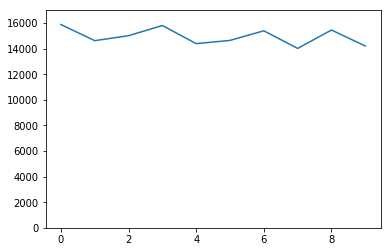

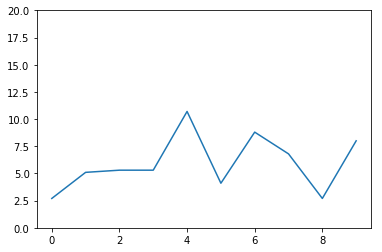

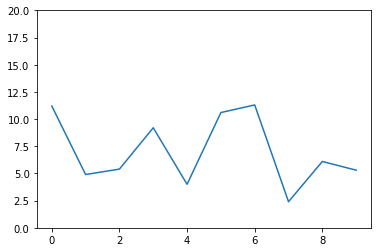

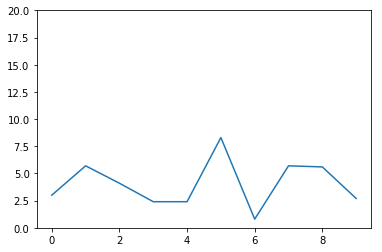

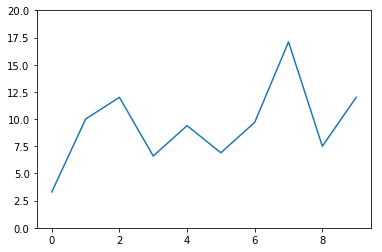

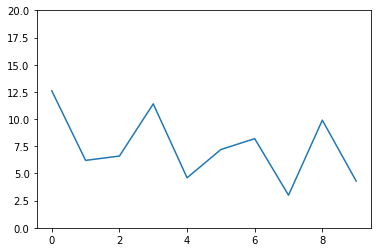

In [25]:
for i in range(5):
    plt.plot(mean_input_rates_per_digit[:,i])
    plt.ylim([0, 17000])
    plt.show()

for i in range(5):
    plt.plot(mean_output_rates_per_digit[:,i])
    plt.ylim([0,20])
    plt.show()

